In [1]:
import os
import pandas as pd
import numpy as np
import re
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Loading and inspecting Kaggle dataset
import kagglehub

path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")
subfolder_path = os.path.join(path, "News _dataset")
files = os.listdir(subfolder_path)
print("Files inside News _dataset:", files)

100%|██████████| 41.0M/41.0M [00:00<00:00, 146MB/s]

Extracting files...


Files inside News _dataset: ['Fake.csv', 'True.csv']


In [3]:
df_fake = pd.read_csv(os.path.join(subfolder_path, "Fake.csv"))
df_true = pd.read_csv(os.path.join(subfolder_path, "True.csv"))

In [4]:
# Adding labels and combining
df_fake["label"] = 0
df_true["label"] = 1
df_combined = pd.concat([df_fake, df_true], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

In [5]:
# Explorin and cleaning
df_combined.drop_duplicates(inplace=True)
print("\nMissing values:\n", df_combined.isnull().sum())


Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [6]:
# Text cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df_combined['text'] = df_combined['text'].apply(clean_text)

In [15]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_combined['text'])
y = df_combined['label']
vectorizer

TfidfVectorizer(max_features=5000)

In [8]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Model 1: Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
best_lr

LogisticRegression(C=10, max_iter=1000)

In [12]:
# Model 2: Random Forest
param_grid_rf = {'n_estimators': [100], 'max_depth': [None]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
best_rf

RandomForestClassifier()

In [13]:
# Model 3: XGBoost
param_grid_xgb = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100]}
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss'), param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4699
           1       1.00      0.99      0.99      4239

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



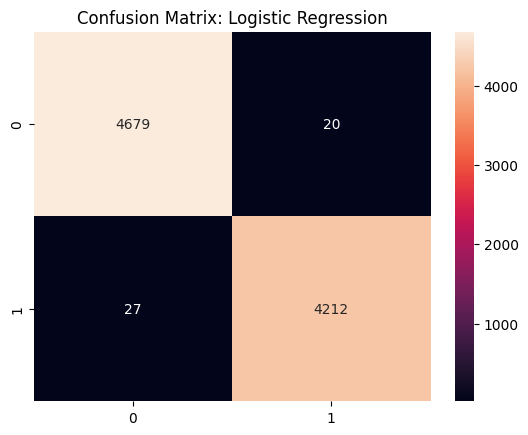


--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4699
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



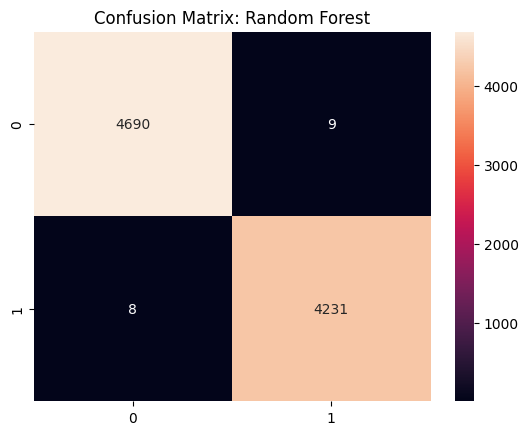


--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4699
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



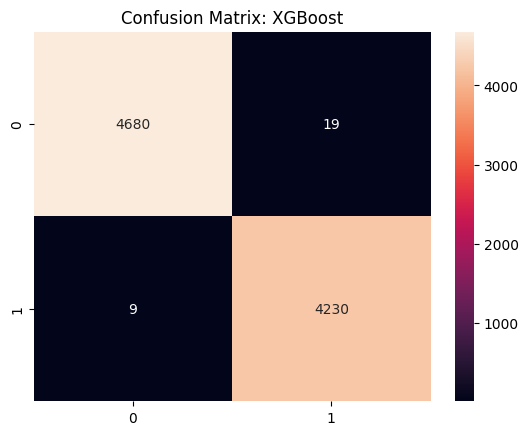

In [16]:
# Model evaluation
models = {'Logistic Regression': best_lr, 'Random Forest': best_rf, 'XGBoost': best_xgb}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

In [17]:
# Error analysis
y_pred = best_rf.predict(X_test)
misclassified_indices = np.where(y_test.values != y_pred)[0]
X_test_df = pd.DataFrame(X_test.toarray())
wrong_samples = X_test_df.iloc[misclassified_indices]

# Viewing misclassified original texts
original_texts = df_combined.iloc[y_test.index[misclassified_indices]]
print("Misclassified samples:\n", original_texts[['text', 'label']].head(10))

Misclassified samples:
                                                     text  label
17316  the last word with lawrence o donnell is seen ...      0
13193  if obama had a communist friend he d be this p...      0
12321   secret police  sounds like a strong arm tacti...      0
18460  san jose reuters  a strong  magnitude quake st...      1
317    putin just trolled the democrats hahavladimir ...      0
20796  why does fox news even give this guy a microph...      0
10624  sarah palin opened her mouth again and people ...      0
15968  washington reuters  president donald trump pre...      1
26616  washington reuters  us house leaders have deci...      1
20541  it s amazing that hillary will likely never be...      0


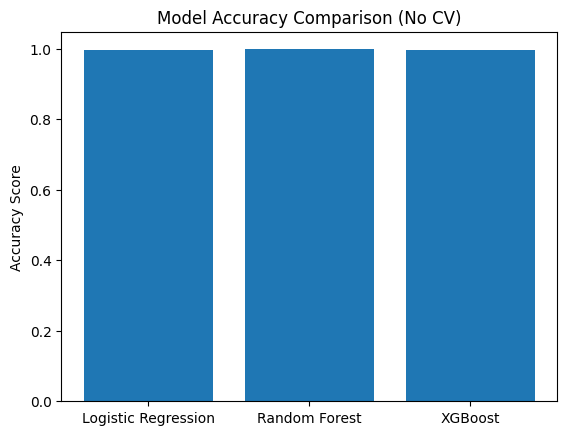

In [18]:
# Model comparison (Cross-Validation not included)
scores = [model.score(X_test, y_test) for model in models.values()]
plt.bar(models.keys(), scores)
plt.title('Model Accuracy Comparison (No CV)')
plt.ylabel('Accuracy Score')
plt.show()

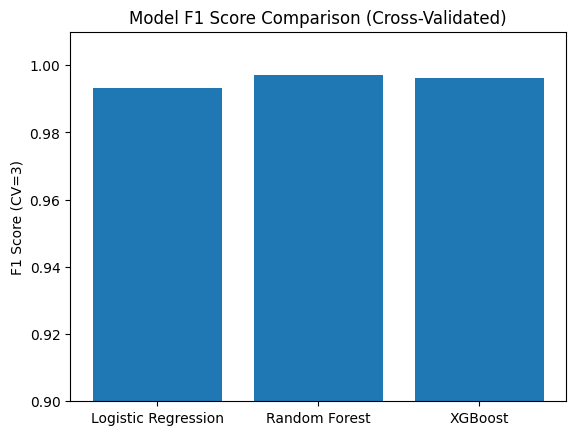

In [19]:
# Model comparison (Cross-Validation included)
scores = [cross_val_score(model, X, y, cv=3, scoring='f1', n_jobs=-1).mean() for model in models.values()]
plt.bar(models.keys(), scores)
plt.title('Model F1 Score Comparison (Cross-Validated)')
plt.ylabel('F1 Score (CV=3)')
plt.ylim(0.9, 1.01)
plt.show()

## Predictions on Live Tweets from X (Twitter)

In [20]:
# X (Twitter) API
# Using Bearer Token
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAMvqzwEAAAAACgV%2BJd5ciPeOj8GZcWDPHGPC0%2Bk%3D4355VvXuONwjRFg1o30OzLs0SzPLZHJBb3tJbtRdW6Ut6RVHIx'
client = tweepy.Client(bearer_token=bearer_token)

In [21]:
# Fetching recent tweets mentioning "fake news"
query = "fake news"
response = client.search_recent_tweets(query=query, tweet_fields=["author_id", "created_at"], max_results=10)

In [22]:
# Cleaning tweet text
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+", '', tweet)
    tweet = re.sub(r"@\w+|#\w+", '', tweet)
    tweet = re.sub(r"[^a-zA-Z\s]", '', tweet)
    return tweet

In [23]:
# Using vectorizer again since one of them was already used
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(df_combined['text'])

TfidfVectorizer(max_features=5000)

In [24]:
# Extracting and cleaning tweet texts
if response.data:
    cleaned_tweets = [clean_tweet(tweet.text) for tweet in response.data]
    X_live = vectorizer.transform(cleaned_tweets)
    preds = best_rf.predict(X_live)
    print("Live Tweet Predictions:\n")
    for i, tweet in enumerate(response.data):
        label = "Real" if preds[i] == 1 else "Fake"
        print(f"Tweet: {tweet.text[:120]}...\n→ Predicted Label: {label}\n")
else:
    print("No tweets found with the given query.")

Live Tweet Predictions:

Tweet: RT @MedinipurSp: We would request devotees to not get mislead by false propaganda by people of vested interests.

Strict...
→ Predicted Label: Fake

Tweet: Here we go.  Grifter on #THEIRABC wants more of our money to go to hamas/UN/'aide'.  
BTW where are they doing all the '...
→ Predicted Label: Fake

Tweet: RT @VoxLiberdade: 🚨 TRUMP DETONA MÍDIA FAKE NEWS: “NINGUÉM ASSISTE MAIS VOCÊS, SÃO RUINS E MENTIROSOS!”

O presidente Tr...
→ Predicted Label: Fake

Tweet: Adivinha, só adivinha quem é que tá espalhando mais essa fake news. https://t.co/eMmuGQgJd2...
→ Predicted Label: Fake

Tweet: RT @vinicios_betiol: Os bolsonaristas passaram o fim de semana xingando a Lady Gaga e os seus fãs, mas agora diante do s...
→ Predicted Label: Fake

Tweet: RT @EricLDaugh: 🚨 NEW: Despite lies that President Trump and Republicans plan to slash Medicaid funding in the spending ...
→ Predicted Label: Fake

Tweet: @SparksN123 Fake news...
→ Predicted Label: Fake

Tweet: RT @